In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

In [ ]:
TEST_SIZE = 0.3
SEED = 123
np.random.seed(SEED)

N_SEARCH_ITER = 4
K = 4
N_JOBS = 4

df = pd.read_csv("Data/bioactivity_clean.csv")

# generate fingeprints: Morgan fingerprint with radius 2
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 2) for smile in df["CANONICAL_SMILES"]]

# convert the RDKit explicit vectors into numpy arrays
np_fps = [np.zeros((1,)) for fp in fps]
for i, fp in enumerate(fps):
    DataStructs.ConvertToNumpyArray(fp, np_fps[i])
X = np.array(np_fps)
y = df["STANDARD_VALUE"].values
y /= np.amax(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

# get a random forest classifiert with 100 trees
rf = RandomizedSearchCV(
    RandomForestRegressor(),
    {
        'n_estimators' : np.arange(100, 1000, 100),
        'max_features' : ['auto', 'sqrt', 'log2']
    },
    n_iter=N_SEARCH_ITER,
    cv=K,
    random_state=SEED,
    n_jobs=N_JOBS,
    verbose=1
).fit(X_train, y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [69]:
rf_nocv = RandomForestRegressor().fit(X_train, y_train)
rf_nocv.score(X_test, y_test)

/home/jonathan/anaconda3/envs/lshack/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.05803622349386195

In [58]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, n_jobs=N_JOBS).fit(X)

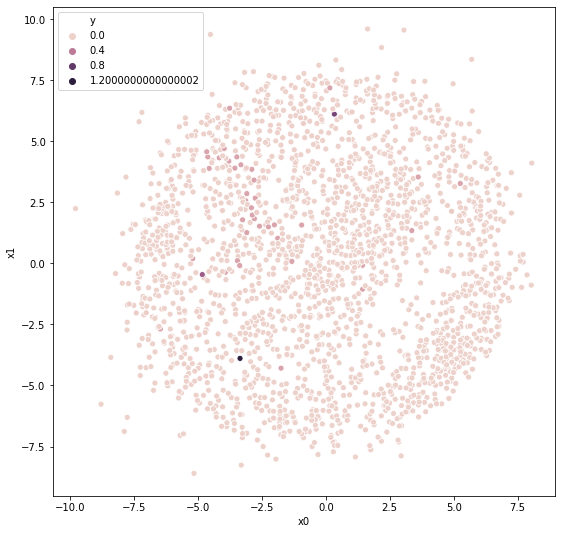

In [66]:
fig, ax = plt.subplots(figsize=(9,9))
sns.scatterplot(x="x0", y="x1", hue="y",
               data=pd.DataFrame({
                   "x0" : mds.embedding_[:,0],
                   "x1" : mds.embedding_[:,1],
                   "y" : y
               }))


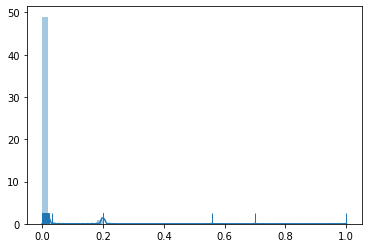

In [67]:
sns.distplot(y, rug=True)